In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DailyDelhiClimate.csv')
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
jumlah_data = df['date'].count()
jumlah_data

1462

In [ ]:
from sklearn.model_selection import train_test_split
dates = df['date'].values
temp  = df['meantemp'].values
x_train, x_test, y_train, y_test= train_test_split(dates, temp, test_size=0.2)

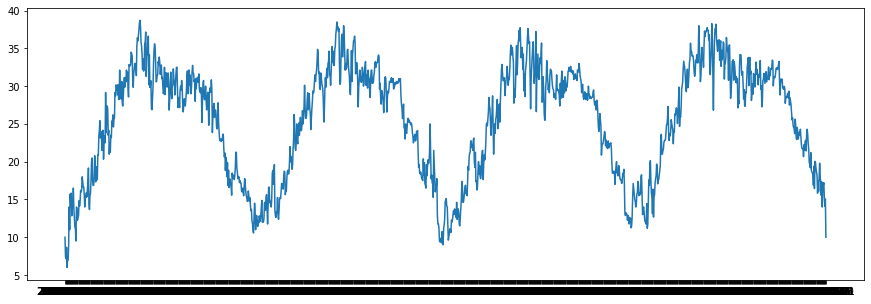

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(dates, temp)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)
val_test = windowed_dataset(y_test, window_size = 60, batch_size = 100, shuffle_buffer=1000)

In [ ]:
minMae = (temp.max() - temp.min())*10/100
minMae

3.2714285714285722

In [ ]:
class my_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < minMae):
            print("MAE has reached below 10%")
            self.model.stop_training = True

callbacks = my_callback()

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics = ["mae"])

In [ ]:
history = model.fit(train_set, 
                    validation_data = val_test,
                    epochs=100,
                    callbacks = callbacks)

Epoch 1/100
15/15 [==============================] - 20s 345ms/step - loss: 25.2650 - mae: 25.7650 - val_loss: 24.5373 - val_mae: 25.0373
Epoch 2/100
15/15 [==============================] - 3s 210ms/step - loss: 25.1660 - mae: 25.6660 - val_loss: 24.4249 - val_mae: 24.9249
Epoch 3/100
15/15 [==============================] - 3s 206ms/step - loss: 25.0533 - mae: 25.5533 - val_loss: 24.3073 - val_mae: 24.8073
Epoch 4/100
15/15 [==============================] - 3s 203ms/step - loss: 24.9356 - mae: 25.4356 - val_loss: 24.1858 - val_mae: 24.6858
Epoch 5/100
15/15 [==============================] - 3s 204ms/step - loss: 24.8150 - mae: 25.3150 - val_loss: 24.0503 - val_mae: 24.5503
Epoch 6/100
15/15 [==============================] - 3s 208ms/step - loss: 24.6760 - mae: 25.1760 - val_loss: 23.9025 - val_mae: 24.4025
Epoch 7/100
15/15 [==============================] - 4s 226ms/step - loss: 24.5247 - mae: 25.0247 - val_loss: 23.7384 - val_mae: 24.2384
Epoch 8/100
15/15 [=====================

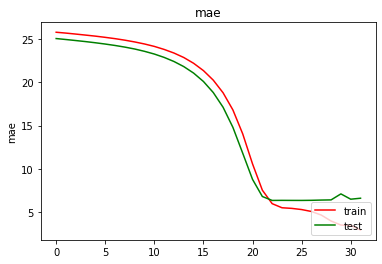

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'], color="red")
plt.plot(history.history['val_mae'], color="green")
plt.title('mae')
plt.ylabel('mae')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

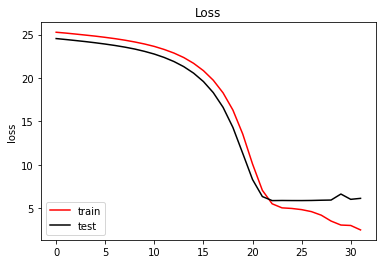

In [ ]:
plt.plot(history.history['loss'], color="red")
plt.plot(history.history['val_loss'], color="black")
plt.title('Loss')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='lower left')
plt.show()